## Homework 3. Classification

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import mutual_info_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

### Data preparation

In [2]:
df = pd.read_csv(
    "../../W2/homework//housing.csv",
    names=[
        "latitude", "longitude", "housing_median_age", "total_rooms",
        "total_bedrooms", "population", "households", "median_income",
        "median_house_value", "ocean_proximity"
        ],
    header=0
    )

In [3]:
df = df.fillna(0)
df["rooms_per_household"] = df.total_rooms/df.households
df["bedrooms_per_room"] = df.total_bedrooms/df.total_rooms
df["population_per_household"] = df.population/df.households
df.sample()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
8508,-118.31,33.88,32.0,2421.0,671.0,1491.0,587.0,3.5644,242300.0,<1H OCEAN,4.124361,0.277158,2.540034


### Question 1. Most frequent ocean_proximity

In [4]:
df.ocean_proximity.mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

### Question 2. Highest correlation

In [5]:
cormat = df.corr()

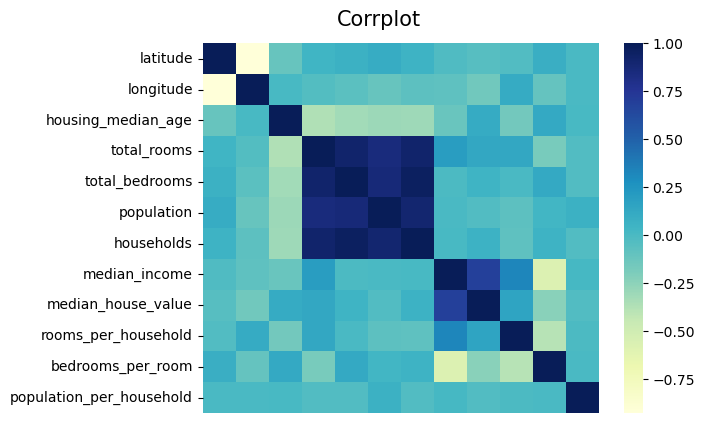

In [6]:
sns.heatmap(cormat, cmap="YlGnBu", xticklabels=False)
plt.suptitle("Corrplot", x=0.4, y=0.95, fontsize=15)
plt.show()

In [7]:
def max_corr(cormat):
    """Find highest (positive) correlation pair"""
    N = len(cormat)
    # coordinates = list(np.unravel_index((cormat - np.eye(N, N)).values.argmax(), (N, N)))
    flat_ind = (cormat - np.eye(N, N)).values.argmax()
    coordinates = [flat_ind//N, flat_ind%N]
    answer = cormat.index[coordinates]

    return answer

max_corr(cormat)

Index(['total_bedrooms', 'households'], dtype='object')

#### Make median_house_value binary

In [8]:
df["log_median_house_value"] = np.log(df.median_house_value)

### Here is a problem with data leakage, cause we supply information about full distribution
### calculating mean value on the full dataset, don't do like that
df.median_house_value = (df.median_house_value > df.median_house_value.mean()).astype(int)
df.rename(columns={"median_house_value": "above_average"}, inplace=True)

#### Split the data

In [9]:
y = df.above_average
del df["above_average"]
X = df

In [10]:
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

y_test_log = X_test.log_median_house_value

X_train,  X_val, y_train, y_val = train_test_split(
    X_full_train, y_full_train, test_size=0.25, random_state=42
    )

y_train_log, y_val_log = X_train.log_median_house_value, X_val.log_median_house_value

X_train.drop(columns=["log_median_house_value"], inplace=True)
X_val.drop(columns=["log_median_house_value"], inplace=True)
X_test.drop(columns=["log_median_house_value"], inplace=True)

len(y_train), len(y_test), len(y_val)

(12384, 4128, 4128)

In [11]:
X_train.reset_index(drop=True, inplace=True), y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True), y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True), y_test.reset_index(drop=True, inplace=True)

(None, None)

### Question 3. Mutual information for categorical

In [12]:
mutual_info_score(X_train.select_dtypes("object").values.reshape(-1, ), y_train).round(2)

0.1

### Question 4. Logistic regression

##### OneHotEncoding (Here I prefer to drop "ISLAND" level)

In [13]:
enc = OneHotEncoder(sparse=False)

In [14]:
X_train = X_train.join(
    pd.DataFrame(
        enc.fit_transform(X_train.select_dtypes("object")), 
        columns=enc.get_feature_names_out()
        )
    )
X_val = X_val.join(
    pd.DataFrame(
        enc.transform(X_val.select_dtypes("object")), 
        columns=enc.get_feature_names_out()
        )
    )
X_test = X_test.join(
    pd.DataFrame(
        enc.transform(X_test.select_dtypes("object")), 
        columns=enc.get_feature_names_out()
        )
    )

X_train.drop(columns=["ocean_proximity"], inplace=True)
X_test.drop(columns=["ocean_proximity"], inplace=True)
X_val.drop(columns=["ocean_proximity"], inplace=True)

# X_train.drop(columns=["ocean_proximity_ISLAND", "ocean_proximity"], inplace=True)
# X_test.drop(columns=["ocean_proximity_ISLAND", "ocean_proximity"], inplace=True)
# X_val.drop(columns=["ocean_proximity_ISLAND", "ocean_proximity"], inplace=True)

In [15]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
score = model.score(X_val, y_val)
score.round(2)

0.84

### Question 5. Feature Elimination

In [16]:
### use Recursive Feature Elimination from sklearn (but here it's trivial)
selector = RFE(model, n_features_to_select=X_train.shape[1]-1, step=1)
selector.fit(X_train, y_train)
X_train.columns[selector.ranking_ > 1]

Index(['total_rooms'], dtype='object')

In [17]:
### alternative
diff_score = []
for column in X_train.columns:
    model.fit(X_train.drop(columns=[column]), y_train)
    diff_score.append(score - model.score(X_val.drop(columns=[column]), y_val).round(2))
X_train.columns[np.abs(diff_score).argmin()]

'total_rooms'

### Question 6. Ridge regression

In [18]:
alphas = [0, 0.01, 0.1, 1, 10]
min_error = []
for alpha in alphas:
    model = Ridge(alpha=alpha, solver="sag", random_state=42)
    model.fit(X_train, y_train_log)
    y_pred = model.predict(X_val)
    min_error.append(mean_squared_error(y_true=y_val_log, y_pred=y_pred, squared=False))
alphas[np.argmin(min_error)]


0